# Bachelor project
The aim of this work is to train convolutional neural network (CNN)  model, that will be capable to identify glaucomatous fundus images with high accuracy and to implement a user-friendly interface for working with this model. This will be tackled via the following objectives:
- Propose and implement preprocessing and augmentation for colorful fundus images.
- Design and implement multiple convolutional neural network (CNN) models, compare their performance, and choose the best model.
- Develop and implement a user-friendly interface to easily interact with the model.

## Preprocessing

### Combine all datasets

In [3]:
import os
import shutil

# New folders
output_dir = "data/combined"
os.makedirs(os.path.join(output_dir, "healthy"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "glaucoma"), exist_ok=True)

# Images from other datasets
dataset_paths = {
    "healthy": [
        "data/datasets/Drishti/NORMAL",
        "data/datasets/LAG_database/LAG_database_part_1 2/non_glaucoma/image",
    ],
    "glaucoma": [
        "data/datasets/Drishti/GLAUCOMA",
        "data/datasets/LAG_database/LAG_database_part_1 2/suspicious_glaucoma/image",
    ],
}

# Copying files from specified paths
for category, paths in dataset_paths.items():
    for path in paths:
        if os.path.exists(path):
            for img_name in os.listdir(path):
                src_path = os.path.join(path, img_name)
                dst_path = os.path.join(output_dir, category, img_name)
                shutil.copy(src_path, dst_path)

# Process RIM-ONE dataset
rimone_path = "data/datasets/RIM-ONE"

if os.path.exists(rimone_path):
    for img_name in os.listdir(rimone_path):
        src_path = os.path.join(rimone_path, img_name)
        # Check if file name starts with 'S' or 'G' for glaucoma, or 'N' for healthy
        if img_name.startswith("S") or img_name.startswith("G"):
            dst_path = os.path.join(output_dir, "glaucoma", img_name)
            shutil.copy(src_path, dst_path)
        elif img_name.startswith("N"):
            dst_path = os.path.join(output_dir, "healthy", img_name)
            shutil.copy(src_path, dst_path)

print("Files successfully combined!")


Files successfully combined!


Check how many images of each class we have.

In [4]:
import os

glaucoma_path = "data/combined/glaucoma"
healthy_path = "data/combined/healthy"

num_glaucoma = len(os.listdir(glaucoma_path)) if os.path.exists(glaucoma_path) else 0
num_healthy = len(os.listdir(healthy_path)) if os.path.exists(healthy_path) else 0

print(f"Glaucoma images: {num_glaucoma}"
      f"\nHealthy images: {num_healthy}")

Glaucoma images: 1855
Healthy images: 3259


From the code above we can tell, that there is almost 2x difference between amount of glaucoma and healthy images. So we have to make an augmentation for glaucoma images, but before that we have to normalize data.

### Image normalization (No need here as it's only rescaling and doesn't help with accuracy)
1. Resize the image to a fixed size for consistency.
2. Convert image from color to grayscale to simplify the image and reduce data complexity.
3. Apply Gaussian Blur to reduce noise and smooth the image.
4. Apply histogram equalization to improve contrast (Enhance the image contrast by spreading out the most frequent intensity values.)
5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD).
6. Normalize the image: scale pixel values to the range [0, 1]

In [5]:
import os
import cv2
import numpy as np

# Directories containing the original images
glaucoma_src = 'data/combined/glaucoma'
healthy_src = 'data/combined/healthy'
    
# Directories where the preprocessed images will be saved
glaucoma_dest = 'data/preprocessed/glaucoma'
healthy_dest = 'data/preprocessed/healthy'
    
# Create destination directories if they don't exist
os.makedirs(glaucoma_dest, exist_ok=True)
os.makedirs(healthy_dest, exist_ok=True)

# Define the target image size (width, height)
img_size = (224, 224)

# Possible preprocessing steps:
# 1. Resize the image to a fixed size for consistency.
# 2. Convert image from color to grayscale to simplify the image and reduce data complexity. (not used, because drops accuracy)
# 3. Apply Gaussian Blur to reduce noise and smooth the image. (improves accuracy a little for bigger model, but drops significantly for smaller model)
# 4. Apply histogram equalization to improve contrast (not used, because it has to receive a grayscale image, which drops accuracy)
# 5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD). (not used, because drops accuracy)
# 6. Normalize the image: scale pixel values to the range [0, 1]
def process_and_save_images(src_folder, dest_folder):
    image_files = os.listdir(src_folder)
    for file in image_files:
        src_path = os.path.join(src_folder, file)
        img = cv2.imread(src_path)
        if img is not None:
            # 1. Resize the image to a fixed size for consistency.
            img = cv2.resize(img, img_size)
            
            # 2. Convert image from color to grayscale to simplify the image and reduce data complexity.
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 3. Apply Gaussian Blur to reduce noise and smooth the image.
            # img = cv2.GaussianBlur(img, (5, 5), 0)
            
            # 4. Apply histogram equalization to improve contrast (Enhance the image contrast by spreading out the most frequent intensity values.)
            # img = cv2.equalizeHist(img)
            
            # 5. Apply a median blur to reduce noise, serving as an approximation for weighted median denoising (WMD).
            # img = cv2.medianBlur(img, 3)

            # To save the image, convert normalized image back to uint8 format (for cv2.imwrite)
            img_to_save = (img).astype(np.uint8)
            dest_path = os.path.join(dest_folder, file)
            cv2.imwrite(dest_path, img_to_save)

# Process and save images for both classes
process_and_save_images(glaucoma_src, glaucoma_dest)
process_and_save_images(healthy_src, healthy_dest)

print("Preprocessing and saving completed!")

Preprocessing and saving completed!


### Augmentation
Just vertical flip for glaucoma images.

In [6]:
import os
import cv2
import numpy as np

# Directories containing preprocessed healthy and glaucoma images
healthy_src = 'data/combined/healthy'
glaucoma_src = 'data/combined/glaucoma'

# Define destination directories for final images
dest_healthy = 'data/augmented/healthy'
dest_glaucoma = 'data/augmented/glaucoma'

# Create destination directories if they don't exist
os.makedirs(dest_healthy, exist_ok=True)
os.makedirs(dest_glaucoma, exist_ok=True)

# Process healthy images: simply copy them to the destination folder
for file in os.listdir(healthy_src):
    src_path = os.path.join(healthy_src, file)
    dst_path = os.path.join(dest_healthy, file)
    image = cv2.imread(src_path)
    if image is not None:
        cv2.imwrite(dst_path, image)

# Process glaucoma images: for each image, apply multiple augmentations and save
for file in os.listdir(glaucoma_src):
    src_path = os.path.join(glaucoma_src, file)
    image = cv2.imread(src_path)
    if image is not None:
        # Save the original image
        dst_path_orig = os.path.join(dest_glaucoma, file)
        cv2.imwrite(dst_path_orig, image)
        
        # Extract base name and extension for creating augmented file names
        base_name, ext = os.path.splitext(file)
        
        # Vertical flip
        img_vflip = cv2.flip(image, 0)
        cv2.imwrite(os.path.join(dest_glaucoma, f"{base_name}_vflip{ext}"), img_vflip)

print("Healthy images copied and glaucoma images augmented (doubled) successfully!")

Healthy images copied and glaucoma images augmented (doubled) successfully!


In [7]:
import os

glaucoma_path = "data/augmented/glaucoma"
healthy_path = "data/augmented/healthy"

num_glaucoma = len(os.listdir(glaucoma_path)) if os.path.exists(glaucoma_path) else 0
num_healthy = len(os.listdir(healthy_path)) if os.path.exists(healthy_path) else 0

print(f"Glaucoma images: {num_glaucoma}"
      f"\nHealthy images: {num_healthy}")

Glaucoma images: 3710
Healthy images: 3259


## Model training

### Splitting into training and testing dataset

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source directories for each class
source_glaucoma = 'data/augmented/glaucoma'
source_healthy = 'data/augmented/healthy'

# Define destination directories for train and test splits
dest_train_glaucoma = 'data/split/train/glaucoma'
dest_train_healthy = 'data/split/train/healthy'
dest_test_glaucoma = 'data/split/test/glaucoma'
dest_test_healthy = 'data/split/test/healthy'

# Create destination directories if they don't exist
os.makedirs(dest_train_glaucoma, exist_ok=True)
os.makedirs(dest_train_healthy, exist_ok=True)
os.makedirs(dest_test_glaucoma, exist_ok=True)
os.makedirs(dest_test_healthy, exist_ok=True)

# Get list of file names from each source directory
files_glaucoma = os.listdir(source_glaucoma)
files_healthy = os.listdir(source_healthy)

# Split file names into training and testing sets for each class
train_glaucoma, test_glaucoma = train_test_split(files_glaucoma, test_size=0.2, random_state=42)
train_healthy, test_healthy = train_test_split(files_healthy, test_size=0.2, random_state=42)

# Copy glaucoma images to corresponding train and test directories
for file in train_glaucoma:
    src_path = os.path.join(source_glaucoma, file)
    dst_path = os.path.join(dest_train_glaucoma, file)
    shutil.copy(src_path, dst_path)

for file in test_glaucoma:
    src_path = os.path.join(source_glaucoma, file)
    dst_path = os.path.join(dest_test_glaucoma, file)
    shutil.copy(src_path, dst_path)

# Copy healthy images to corresponding train and test directories
for file in train_healthy:
    src_path = os.path.join(source_healthy, file)
    dst_path = os.path.join(dest_train_healthy, file)
    shutil.copy(src_path, dst_path)

for file in test_healthy:
    src_path = os.path.join(source_healthy, file)
    dst_path = os.path.join(dest_test_healthy, file)
    shutil.copy(src_path, dst_path)

print("Data split into train and test folders successfully!")

Data split into train and test folders successfully!


### Training

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC

# ---------- custom F1 metric ----------
def f1_score(y_true, y_pred):
    """Binary F1‑score averaged over the batch."""
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, "float"))
    fp = K.sum(K.cast((1 - y_true) * y_pred, "float"))
    fn = K.sum(K.cast(y_true * (1 - y_pred), "float"))

    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    return 2 * precision * recall / (precision + recall + K.epsilon())

#### v1 (Strongest model)

In [ ]:
import os
import pickle
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Parameters: image dimensions, batch size, and number of epochs
img_width, img_height = 224, 224
batch_size = 32
epochs = 15

# Data directories for training and testing
train_data_dir = 'data/split/train'
test_data_dir = 'data/split/test'

# Create ImageDataGenerators with basic preprocessing (rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255) 

# Load training data from directory with explicitly defined class order: first 'healthy', then 'glaucoma'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma']  # Explicit class order
)

# Load test data from directory; disable shuffling for accurate evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Keep order for proper evaluation
    classes=['healthy', 'glaucoma']
)

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    InputLayer(shape=(img_width, img_height, 3)),        # Input layer for RGB images
    Conv2D(32, (3, 3), activation='relu'),               # First convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                        # First max pooling layer
    Conv2D(64, (3, 3), activation='relu'),               # Second convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                        # Second max pooling layer
    Conv2D(128, (3, 3), activation='relu'),              # Third convolutional layer
    MaxPooling2D(pool_size=(2, 2)),                        # Third max pooling layer
    Flatten(),                                           # Flatten the feature maps
    Dense(128, activation='relu'),                       # Fully connected layer
    Dropout(0.5),                                        # Dropout layer for regularization
    Dense(1, activation='sigmoid')                       # Output layer for binary classification
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[
                'accuracy',
                Precision(name='precision'),
                Recall(name='recall'),
                AUC(name='auc'),          # ROC‑AUC
                AUC(name='prc', curve='PR')])

# Display the model architecture
model.summary()

# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Save history of training to a file
history_path = "models/history_v1.pkl"
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# Evaluate the model performance on the test data
metrics = model.evaluate(test_generator, return_dict=True, verbose=0)

print(f"Test loss      : {metrics['loss']:.4f}")
print(f"Test accuracy  : {metrics['accuracy']:.4f}")
print(f"Test precision : {metrics['precision']:.4f}")
print(f"Test recall    : {metrics['recall']:.4f}")
print(f"Test ROC‑AUC   : {metrics['auc']:.4f}")
print(f"Test PR‑AUC    : {metrics['prc']:.4f}")

# Save the trained model in Keras format
model.save("models/cnn_model_v1.keras")

Found 5575 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 360ms/step - accuracy: 0.5966 - auc: 0.6283 - f1_score: 0.4931 - loss: 0.6641 - prc: 0.6380 - precision: 0.6097 - recall: 0.6400 - val_accuracy: 0.7826 - val_auc: 0.8521 - val_f1_score: 0.4837 - val_loss: 0.5153 - val_prc: 0.8470 - val_precision: 0.7840 - val_recall: 0.8167
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 355ms/step - accuracy: 0.7557 - auc: 0.8327 - f1_score: 0.5242 - loss: 0.5097 - prc: 0.8411 - precision: 0.7730 - recall: 0.7672 - val_accuracy: 0.8264 - val_auc: 0.9093 - val_f1_score: 0.4826 - val_loss: 0.3915 - val_prc: 0.9114 - val_precision: 0.8531 - val_recall: 0.8140
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 356ms/step - accuracy: 0.8135 - auc: 0.8905 - f1_score: 0.5303 - loss: 0.4191 - prc: 0.8966 - precision: 0.8232 - recall: 0.8291 - val_accuracy: 0.8379 - val_auc: 0.9320 - val_f1_score: 0.4690 - val_loss: 0.3682 - val_prc: 0.9389 - val_precision: 0.9057 - val_recall: 0.7763
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 63s

#### v2 (Weakest model)

In [ ]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Parameters: image dimensions, batch size, and number of epochs
img_width, img_height = 224, 224
batch_size = 32
epochs = 15

# Data directories for training and testing
train_data_dir = 'data/split/train'
test_data_dir = 'data/split/test'

# Create ImageDataGenerators with basic preprocessing (rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255) 

# Load training data from directory with explicitly defined class order: first 'healthy', then 'glaucoma'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma']  # Explicit class order
)

# Load test data from directory; disable shuffling for accurate evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Keep order for proper evaluation
    classes=['healthy', 'glaucoma']
)

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    InputLayer(shape=(img_width, img_height, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[
                'accuracy',
                Precision(name='precision'),
                Recall(name='recall'),
                AUC(name='auc'),          # ROC‑AUC
                AUC(name='prc', curve='PR')])

# Display the model architecture
model.summary()

# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Save history of training to a file
history_path = "models/history_v2.pkl"
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# Evaluate the model performance on the test data
metrics = model.evaluate(test_generator, return_dict=True, verbose=0)

print(f"Test loss      : {metrics['loss']:.4f}")
print(f"Test accuracy  : {metrics['accuracy']:.4f}")
print(f"Test precision : {metrics['precision']:.4f}")
print(f"Test recall    : {metrics['recall']:.4f}")
print(f"Test ROC‑AUC   : {metrics['auc']:.4f}")
print(f"Test PR‑AUC    : {metrics['prc']:.4f}")

# Save the trained model in Keras format
model.save("models/cnn_model_v2.keras")

Found 5575 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 197136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     6,308,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,308,865 (24.07 MB)

 Trainable params: 6,308,865 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.6076 - auc: 0.6433 - f1_score: 0.4246 - loss: 0.6844 - prc: 0.6451 - precision: 0.6420 - recall: 0.6100 - val_accuracy: 0.8422 - val_auc: 0.9025 - val_f1_score: 0.5001 - val_loss: 0.4248 - val_prc: 0.8939 - val_precision: 0.8355 - val_recall: 0.8760
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.7923 - auc: 0.8674 - f1_score: 0.5193 - loss: 0.4594 - prc: 0.8623 - precision: 0.8013 - recall: 0.8060 - val_accuracy: 0.8357 - val_auc: 0.9247 - val_f1_score: 0.4664 - val_loss: 0.3935 - val_prc: 0.9235 - val_precision: 0.9078 - val_recall: 0.7695
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.8263 - auc: 0.9072 - f1_score: 0.5374 - loss: 0.3962 - prc: 0.9121 - precision: 0.8417 - recall: 0.8376 - val_accuracy: 0.8637 - val_auc: 0.9348 - val_f1_score: 0.4918 - val_loss: 0.3492 - val_prc: 0.9346 - val_precision: 0.8954 - val_recall: 0.8423
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s

#### v3 (Medium model)

In [ ]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Parameters: image dimensions, batch size, and number of epochs
img_width, img_height = 224, 224
batch_size = 32
epochs = 15

# Data directories for training and testing
train_data_dir = 'data/split/train'
test_data_dir = 'data/split/test'

# Create ImageDataGenerators with basic preprocessing (rescaling)
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255) 

# Load training data from directory with explicitly defined class order: first 'healthy', then 'glaucoma'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=['healthy', 'glaucoma']  # Explicit class order
)

# Load test data from directory; disable shuffling for accurate evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # Keep order for proper evaluation
    classes=['healthy', 'glaucoma']
)

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    InputLayer(shape=(img_width, img_height, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[
                'accuracy',
                Precision(name='precision'),
                Recall(name='recall'),
                AUC(name='auc'),          # ROC‑AUC
                AUC(name='prc', curve='PR')])

# Display the model architecture
model.summary()

# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Save history of training to a file
history_path = "models/history_v3.pkl"
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# Evaluate the model performance on the test data
metrics = model.evaluate(test_generator, return_dict=True, verbose=0)

print(f"Test loss      : {metrics['loss']:.4f}")
print(f"Test accuracy  : {metrics['accuracy']:.4f}")
print(f"Test precision : {metrics['precision']:.4f}")
print(f"Test recall    : {metrics['recall']:.4f}")
print(f"Test ROC‑AUC   : {metrics['auc']:.4f}")
print(f"Test PR‑AUC    : {metrics['prc']:.4f}")

# Save the trained model in Keras format
model.save("models/cnn_model_v2.keras")

Found 5575 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.5986 - auc: 0.6361 - f1_score: 0.4870 - loss: 0.6651 - prc: 0.6375 - precision: 0.6218 - recall: 0.6163 - val_accuracy: 0.7597 - val_auc: 0.8950 - val_f1_score: 0.4041 - val_loss: 0.5172 - val_prc: 0.8896 - val_precision: 0.9078 - val_recall: 0.6105
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 51s 289ms/step - accuracy: 0.7695 - auc: 0.8465 - f1_score: 0.5158 - loss: 0.4956 - prc: 0.8464 - precision: 0.7972 - recall: 0.7651 - val_accuracy: 0.8451 - val_auc: 0.9103 - val_f1_score: 0.5112 - val_loss: 0.3956 - val_prc: 0.9051 - val_precision: 0.8239 - val_recall: 0.9016
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 51s 294ms/step - accuracy: 0.8119 - auc: 0.8834 - f1_score: 0.5278 - loss: 0.4353 - prc: 0.8855 - precision: 0.8181 - recall: 0.8286 - val_accuracy: 0.8529 - val_auc: 0.9311 - val_f1_score: 0.4885 - val_loss: 0.3514 - val_prc: 0.9343 - val_precision: 0.8863 - val_recall: 0.8302
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 51s

## Testing

Model loaded from models/cnn_model_v3.keras
Found 1394 images belonging to 2 classes.


c:\Users\sahurai\Desktop\Bakalarka\Code\BachelorProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step

Keras evaluate metrics:
accuracy    : 0.8809
loss        : 0.2761

Scikit‑learn metrics:
accuracy : 0.8809
recall   : 0.8450
precision: 0.9248
f1_score : 0.8831

Classification report:
              precision    recall  f1-score   support

     healthy       0.84      0.92      0.88       652
    glaucoma       0.92      0.85      0.88       742

    accuracy                           0.88      1394
   macro avg       0.88      0.88      0.88      1394
weighted avg       0.88      0.88      0.88      1394



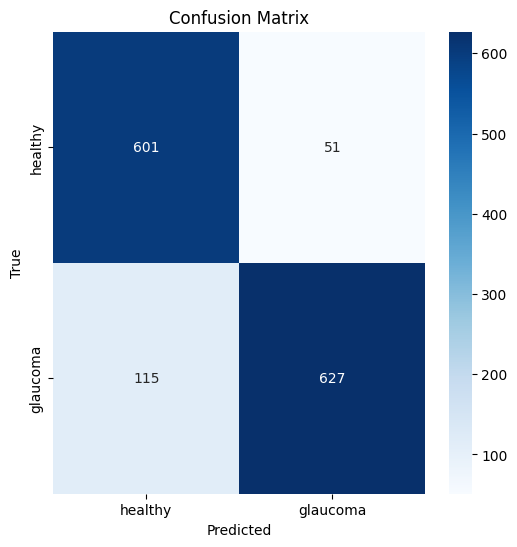

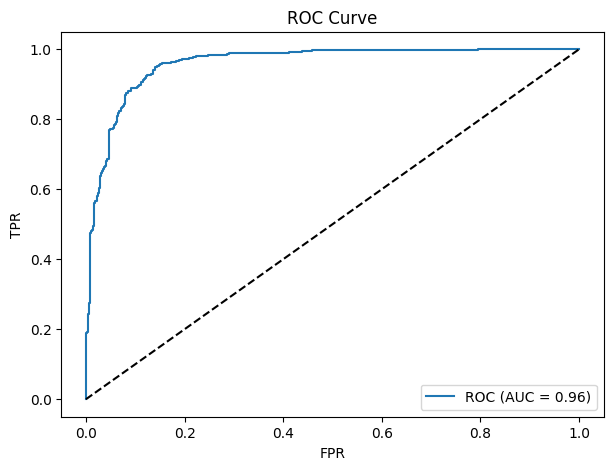

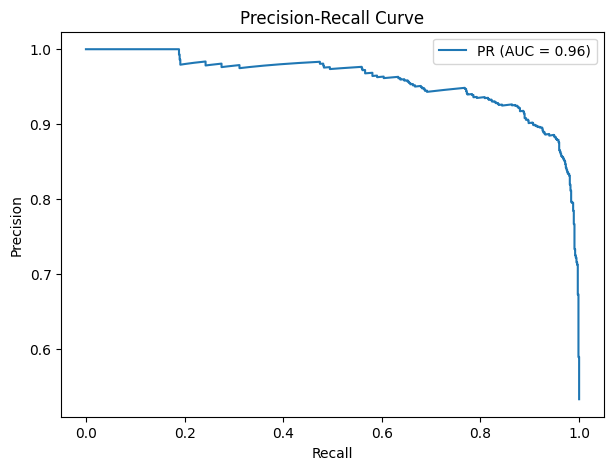

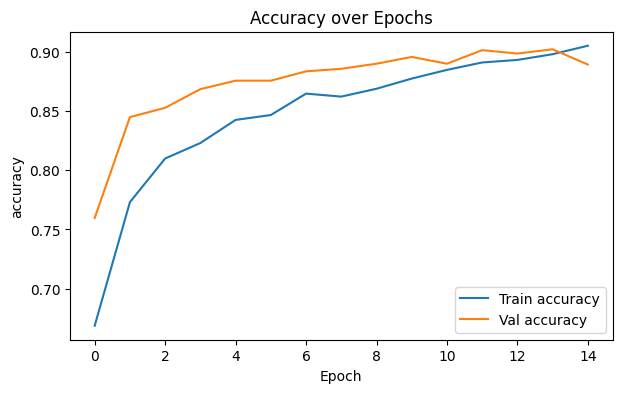

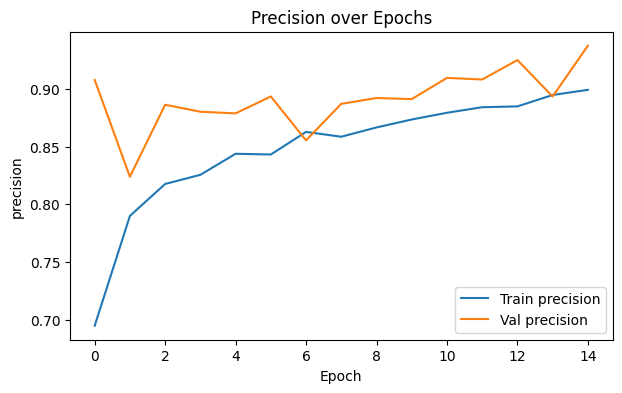

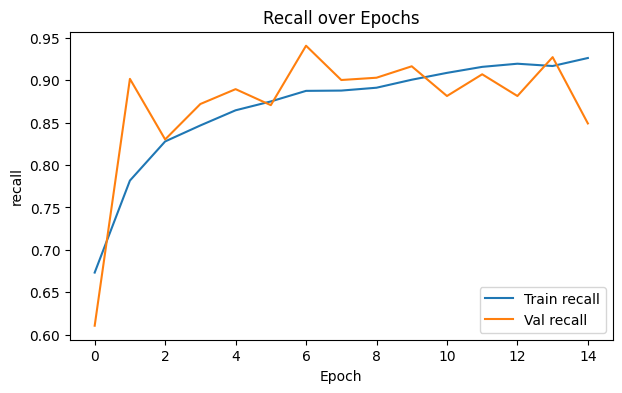

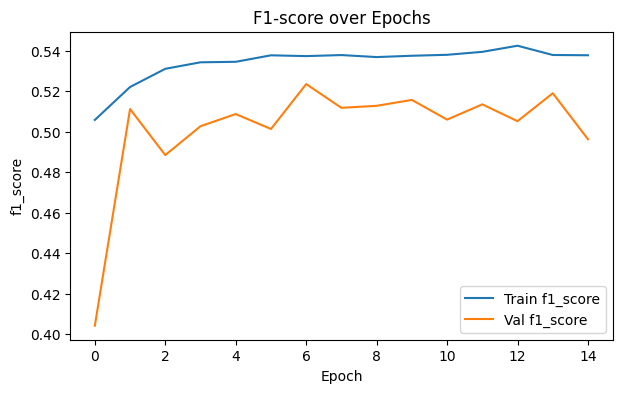

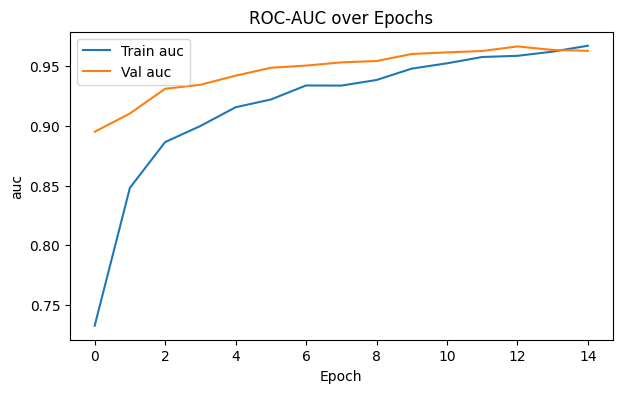

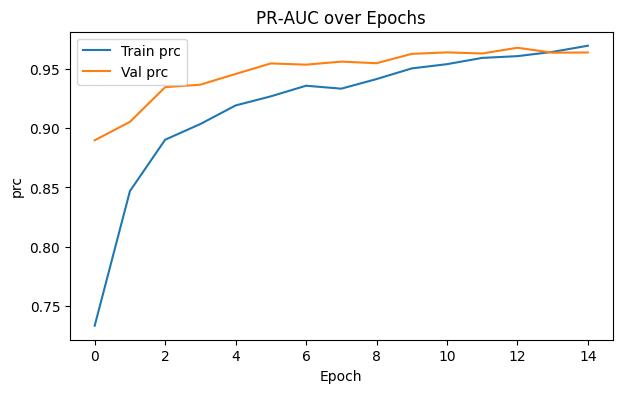

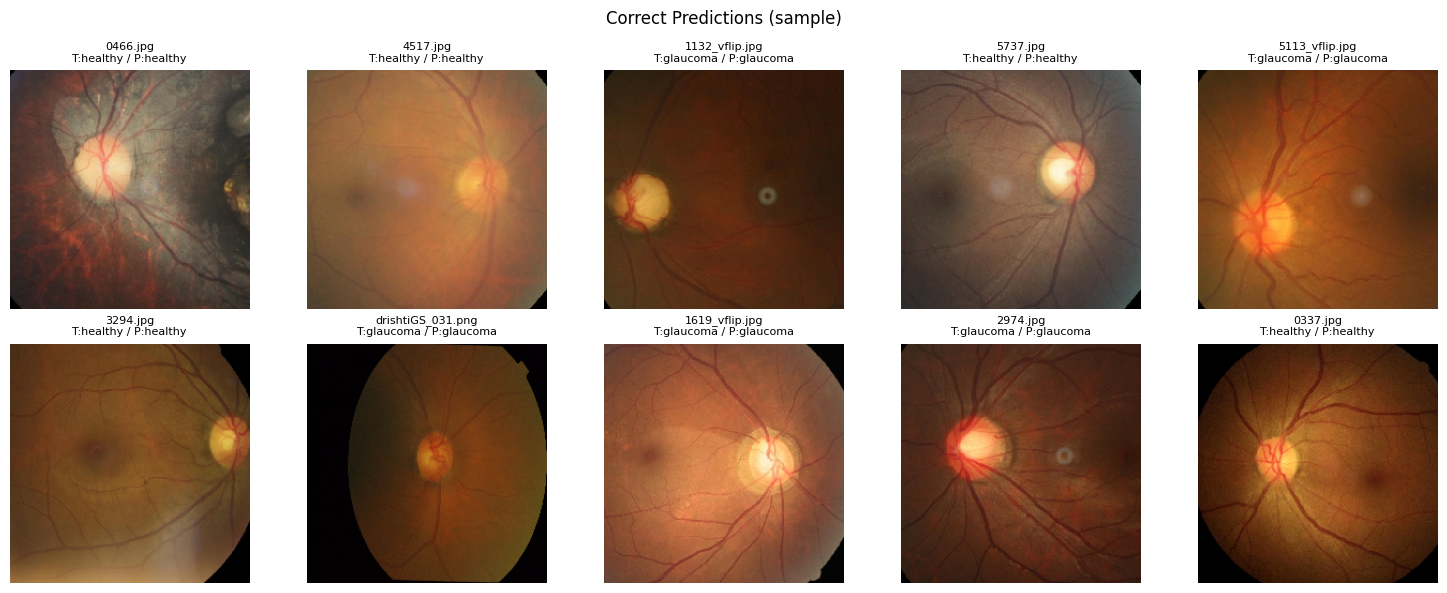

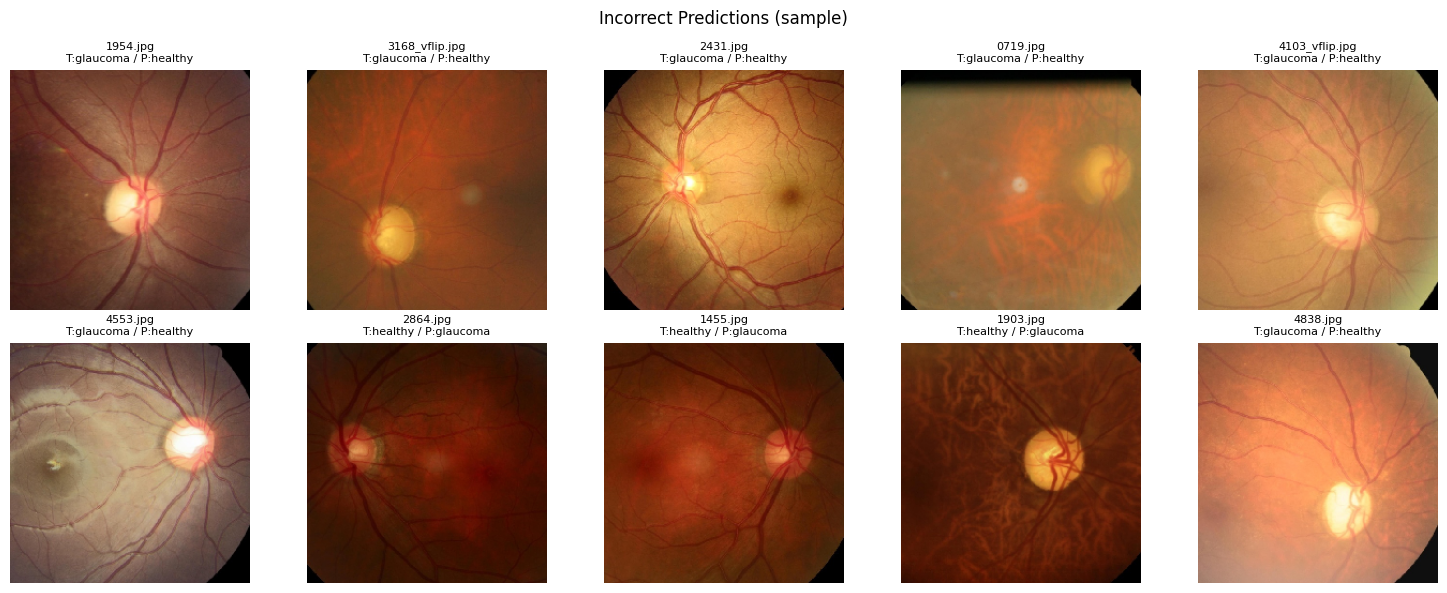


Total correct : 1228
Total incorrect: 166


In [ ]:
import os
import math
import random
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve)

# ---------- custom F1 (must match the one used during training) ----------
def f1_score_keras(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, "float"))
    fp = K.sum(K.cast((1 - y_true) * y_pred, "float"))
    fn = K.sum(K.cast(y_true * (1 - y_pred), "float"))

    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    return 2 * precision * recall / (precision + recall + K.epsilon())
# ------------------------------------------------------------------------

# Parameters
img_width, img_height = 224, 224
batch_size = 32

# Paths
model_path   = "models/cnn_model_v3.keras"
history_path = "models/history_v3.pkl"

# Load model with custom metric
model = load_model(model_path, custom_objects={'f1_score': f1_score_keras})
print("Model loaded from", model_path)

# Test data generator
test_data_dir = 'data/split/test'
classes = ['healthy', 'glaucoma']
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    classes=classes
)

# Predict
test_generator.reset()
pred_probs  = model.predict(test_generator, verbose=1).ravel()
pred_labels = (pred_probs >= 0.5).astype(int)
true_labels = test_generator.classes

# ----- Keras evaluate (prints the same metrics logged during training) -----
keras_metrics = model.evaluate(test_generator, verbose=0, return_dict=True)
print("\nKeras evaluate metrics:")
for k, v in keras_metrics.items():
    print(f"{k:12s}: {v:.4f}")

# ----- scikit‑learn metrics (for double‑check) -----
acc  = accuracy_score(true_labels, pred_labels)
rec  = recall_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels)
f1   = f1_score(true_labels, pred_labels)
print("\nScikit‑learn metrics:")
print(f"accuracy : {acc:.4f}")
print(f"recall   : {rec:.4f}")
print(f"precision: {prec:.4f}")
print(f"f1_score : {f1:.4f}")

print("\nClassification report:")
print(classification_report(true_labels, pred_labels, target_names=classes))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

# PR curve
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, pred_probs)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, label=f'PR (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall Curve')
plt.legend()
plt.show()

# ----- history curves -----
try:
    with open(history_path, "rb") as f:
        hist = pickle.load(f)

    def plot_metric(metric_name, title=None):
        if metric_name in hist and f'val_{metric_name}' in hist:
            plt.figure(figsize=(7, 4))
            plt.plot(hist[metric_name], label=f'Train {metric_name}')
            plt.plot(hist[f"val_{metric_name}"], label=f'Val {metric_name}')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name)
            plt.title(title or metric_name)
            plt.legend()
            plt.show()

    plot_metric('accuracy', 'Accuracy over Epochs')
    plot_metric('precision', 'Precision over Epochs')
    plot_metric('recall',    'Recall over Epochs')
    plot_metric('auc',       'ROC‑AUC over Epochs')
    plot_metric('prc',       'PR‑AUC over Epochs')

except Exception as e:
    print("Could not load history:", e)

# ----- Correct / incorrect samples -----
steps = math.ceil(test_generator.samples / test_generator.batch_size)
X_test, Y_test = [], []
for _ in range(steps):
    x_batch, y_batch = next(test_generator)
    X_test.append(x_batch)
    Y_test.append(y_batch)
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

correct_idx   = np.where(pred_labels == true_labels)[0]
incorrect_idx = np.where(pred_labels != true_labels)[0]

def visualize(indices, title, n=10):
    sel = indices[:n]
    rows = 2 if len(sel) > 5 else 1
    cols = math.ceil(len(sel) / rows)
    plt.figure(figsize=(cols * 3, rows * 3))
    for j, idx in enumerate(sel):
        plt.subplot(rows, cols, j + 1)
        plt.imshow(X_test[idx])
        plt.axis('off')
        plt.title(
            f"{os.path.basename(test_generator.filenames[idx])}\n"
            f"T:{classes[int(Y_test[idx])]} / P:{classes[pred_labels[idx]]}",
            fontsize=8
        )
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize(random.sample(correct_idx.tolist(), min(10, len(correct_idx))), "Correct Predictions (sample)")
visualize(random.sample(incorrect_idx.tolist(), min(10, len(incorrect_idx))), "Incorrect Predictions (sample)")

print(f"\nTotal correct : {len(correct_idx)}")
print(f"Total incorrect: {len(incorrect_idx)}")